In [63]:
# Let's import the needed packages
# To deal with arrays 
import xarray as xr
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np

# To plot curves
import matplotlib.pyplot as plt
import seaborn as sns

# To plot the map
import cartopy.crs as ccrs

# Importing Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Prediction Scores
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dimensionality reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#import our useful functions 
import useful_functions

# One-month prediction of El Nino Events

In [64]:
# Get the data for a 1-month prediction
X, y = useful_functions.get_data("data/preprocessed_data/nino_dataset_1m.npz")

==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]


In [65]:
# Get the data without the seasonal cycle for 1-month prediction
X_wo_sc, y_wo_sc = useful_functions.get_data("data/preprocessed_data/nino_dataset_1m_seasonal.npz")

==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]


## 1. Baseline - LDA

In this part, we explore a simple model, to have a first prediction score and then decide guideines for the rest of our work. We also want to compare prediction with and without the seasonal cycle.

### 1.1 First evaluation

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== TRAIN ====
Accuracy for TRAIN data: 0.984
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.860
     AUC for TEST data: 0.947


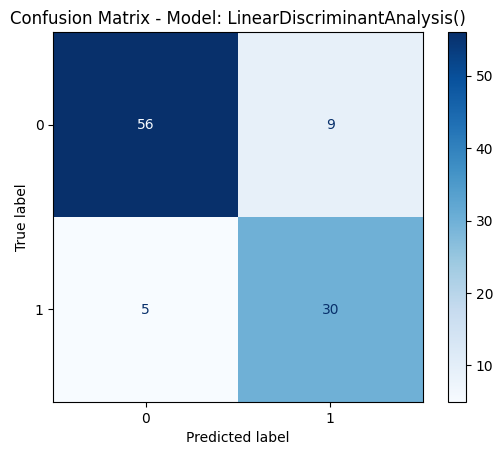

In [66]:
# Evaluation with data with the seasonal cycle 

# Split the data for a first evaluation
X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Test the model
accuracy_score_test_lda, roc_auc_score_test_lda = useful_functions.test_model(lda, X_train,
                                                                              X_test, y_train, y_test)

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== TRAIN ====
Accuracy for TRAIN data: 0.976
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.610
     AUC for TEST data: 0.628


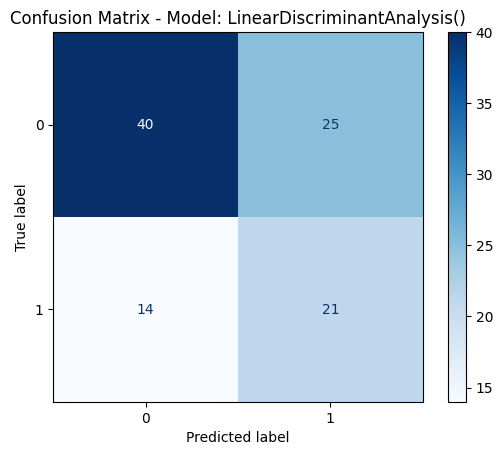

In [67]:
# Evaluation with data without the seasonal cycle 

# Split the data for a first evaluation
X_train_wo_sc, X_test_wo_sc, y_train_wo_sc, y_test_wo_sc = useful_functions.split_scale_data(X_wo_sc, y_wo_sc, RANDOM_SPLIT = False, train_size = 374)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Test the model
accuracy_score_test_lda_wo_sc, roc_auc_score_test_lda_wo_sc = useful_functions.test_model(lda, X_train_wo_sc,
                                                                              X_test_wo_sc, y_train_wo_sc, y_test_wo_sc)

In [68]:
# Find which data predicts the best: 
if(accuracy_score_test_lda_wo_sc > accuracy_score_test_lda): 
    print("Data without the seasonal cycle is the best for prediction")
    print(f"Difference of score{accuracy_score_test_lda_wo_sc - accuracy_score_test_lda}")
else: 
    print("Data with the seasonal cycle is the best for prediction")
    print(f"Difference of score: {accuracy_score_test_lda - accuracy_score_test_lda_wo_sc}")

Data with the seasonal cycle is the best for prediction
Difference of score: 0.25


What we can conclude from this part: 

1) Seasonality is useful to predict El Nino Events. This is not surprising because El Niño events tend to begin during the spring or summer of the Northern Hemisphere (March to May) and they generally reach their peak intensity between November and February (Northern Hemisphere winter). This is when SST anomaly in the central and eastern equatorial Pacific is at its highest.
We are going to use data with season information in the next part of the notebook.

2) We can see here that the model is overfitting !!!
Before trying this model, we will try to reduce the overfitting by performing dimensionality reduction.

### 1.2 Dimensionality reduction: PCA

Text(0.5, 1.0, 'Cumulative Explained Variance by Principal Components')

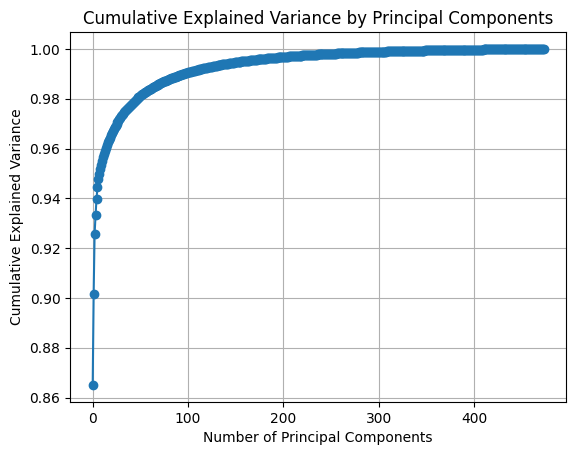

In [69]:
# PCA
PCA_sst = PCA(n_components = None)
PCA_sst.fit(X)

# Computation of the explained variance ratio
explained_variance_ratio_sst = PCA_sst.explained_variance_ratio_

# Plot of the explained variance ratio
plt.grid()
plt.plot(np.cumsum(explained_variance_ratio_sst), marker = 'o')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')

In [70]:
# We work with the original data and split it 
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    X, y, RANDOM_SPLIT=False, train_size=374
    )

X_train_cv, X_validation, y_train_cv, y_validation = useful_functions.split_scale_data(
    X_train, y_train, RANDOM_SPLIT=False, train_size=300, scale= False
    )

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (300, 64800)
Shape of y_train: (300,)
Shape of X_test: (74, 64800)
Shape of y_test: (74,)


Best value of p - PCA : 16
Train Score for the best p: 0.9233333333333333
Test Score for the best p: 0.9324324324324325


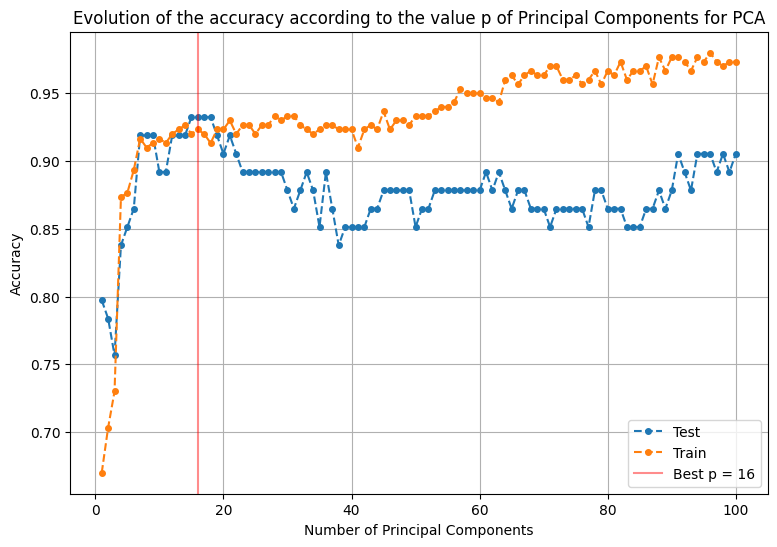

In [71]:
best_p_value, best_test_score_pca = useful_functions.validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, LinearDiscriminantAnalysis(),
                                    dim_max=100, verbose = True)

==== TRAIN ====
Accuracy for TRAIN data: 0.917
     AUC for TRAIN data: 0.968
==== TEST ====
Accuracy for TEST data: 0.870
     AUC for TEST data: 0.946


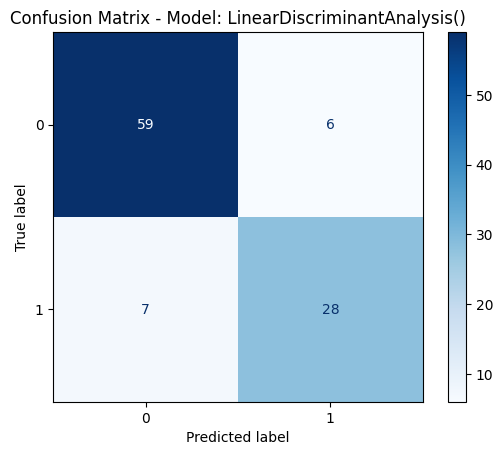

In [72]:
# PCA with p principal components
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Test the model
accuracy_score_test_LDA, roc_auc_score_test_LDA = useful_functions.test_model(lda, X_train_projected,
                                                                            X_test_projected,
                                                                            y_train, y_test)

## 2. Ridge and Lasso for classification task

In this part, we explore the use of Ridge and Lasso Regressions for the classification task, as we want to perform regularization to prevent overfitting.

### 2.1 Ridge Classification 

c:\ENPC\anaconda3\envs\climate\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.73634e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


==== TRAIN ====
Accuracy for TRAIN data: 1.000
     AUC for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.850
     AUC for TEST data: 0.916


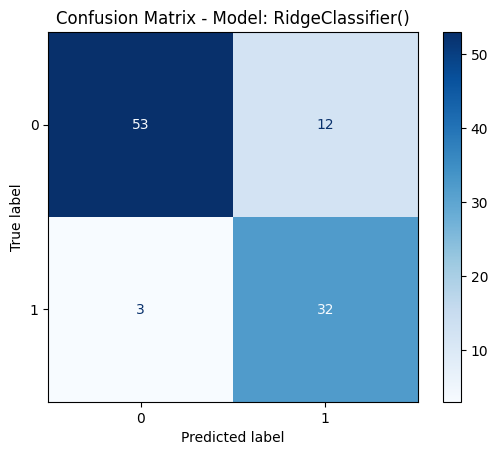

In [73]:
# Define and evaluate the Ridge classifier on the original training and test data
ridge = RidgeClassifier(alpha = 1.0)  # Default hyperparameter

# Test the model
accuracy_score_test_ridge, roc_auc_score_test_ridge = useful_functions.test_model(ridge, X_train,
                                                                              X_test, y_train, y_test)

In [74]:
best_lambda, max_accuracy_validation_Ridge, train_accuracy_Ridge, lambda_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = useful_functions.validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=1,
                                                                                           high_power=7,
                                                                                           nb_points=100)


Best parameter value after validation: 12328.5
Accuracy for training: 0.987
Accuracy for validation: 0.905


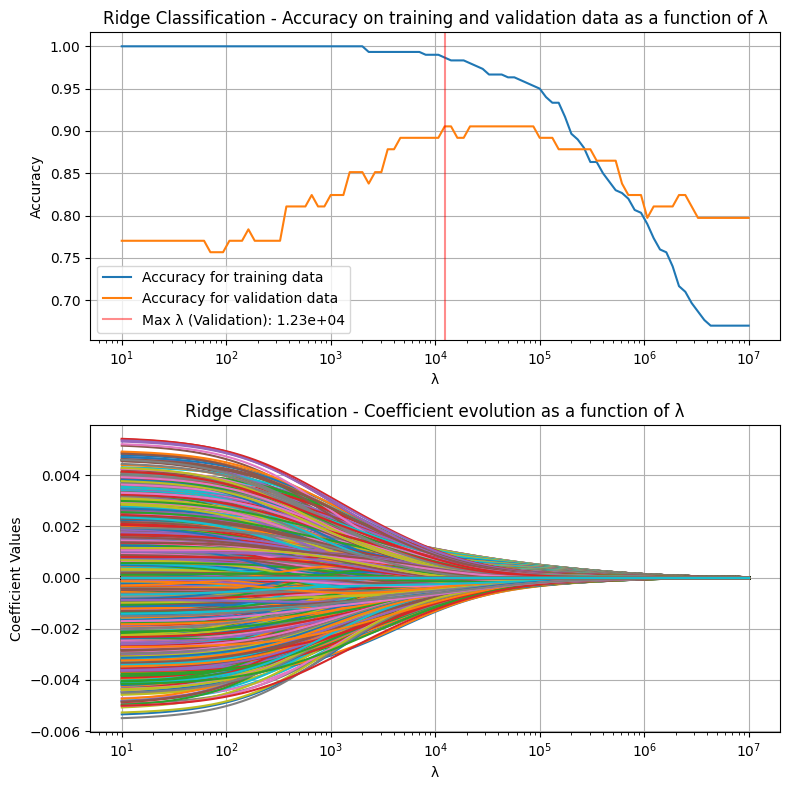

In [75]:
# Plot accuracy and coefficient evolution as a function of lambda
plt.figure(figsize = [8, 8])

# Plot accuracy for training and validation sets
plt.subplot(2, 1, 1)
plt.semilogx(lambda_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(lambda_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_lambda, color = 'r', linestyle = '-', label = f'Max λ (Validation): {best_lambda:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.title('Ridge Classification - Accuracy on training and validation data as a function of λ')
plt.grid()

# Plot coefficient evolution
plt.subplot(2, 1, 2)
plt.semilogx(lambda_values, coefficients[:, 0])
plt.xlabel('λ')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Ridge Classification - Coefficient evolution as a function of λ')

plt.tight_layout()
plt.show()

==== TRAIN ====
Accuracy for TRAIN data: 0.979
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.910
     AUC for TEST data: 0.959


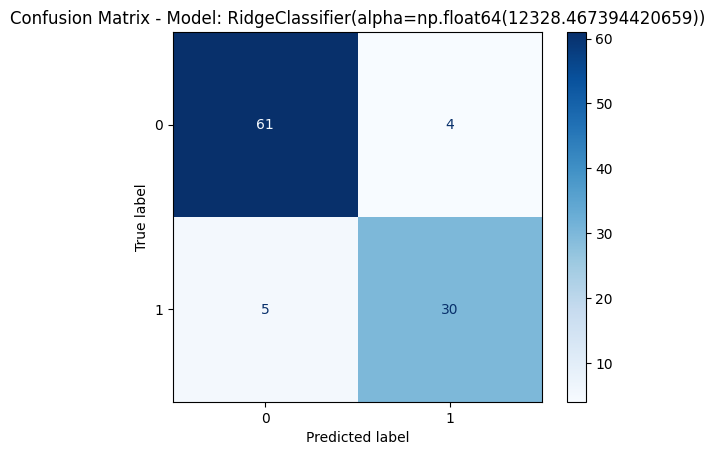

In [76]:
# Evaluate the best Ridge model
ridge = RidgeClassifier(alpha = best_lambda)

# Test the model
accuracy_score_test_RIDGE, roc_auc_score_test_RIDGE = useful_functions.test_model(ridge, X_train,X_test,
                                                                               y_train, y_test)

### 2.2 Lasso Classification

In this part, we will use the Lasso algorithm to perform a regularization of our model, trying to prevent overfitting. As there is no "LassoClassifier" function, we will use the LogisticRegression function with penalty parameter set to "l1".

==== TRAIN ====
Accuracy for TRAIN data: 1.000
     AUC for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.880
     AUC for TEST data: 0.957


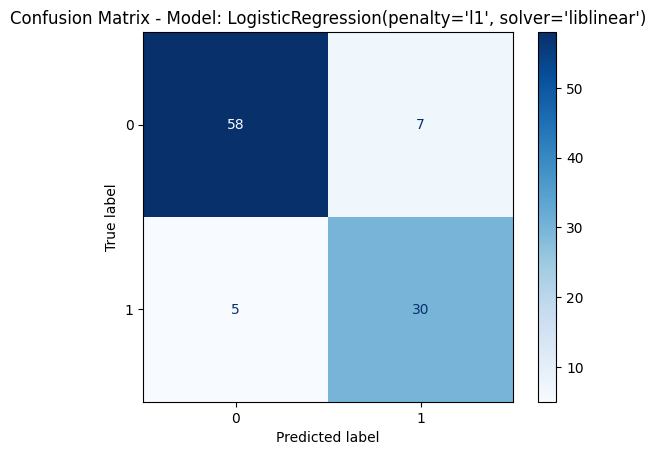

In [77]:
# Define the classifier
lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1.0) 

# Test the model
accuracy_score_test_lasso, roc_auc_score_test_lasso = useful_functions.test_model(lasso, X_train,
                                                                              X_test, y_train, y_test)

In [78]:
best_C, max_accuracy_validation_Lasso, train_accuracy_Lasso, C_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = useful_functions.validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=-3,
                                                                                           high_power=2,
                                                                                           nb_points=50,
                                                                                           Ridge=False)


Best parameter value after validation: 0.2
Accuracy for training: 0.957
Accuracy for validation: 0.946


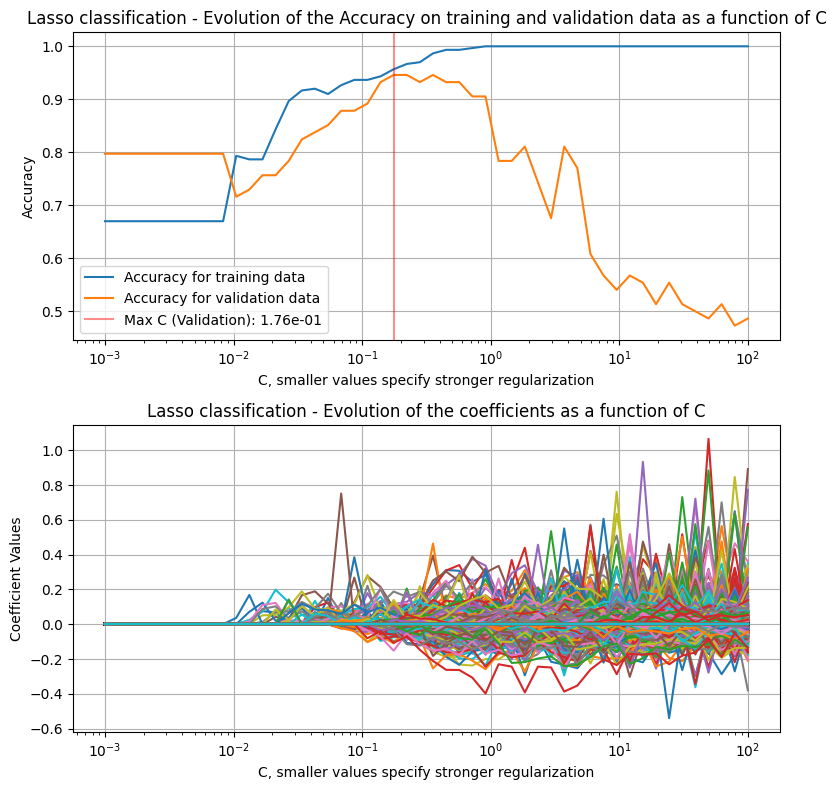

In [79]:
# Plot the results
plt.figure(figsize = [8,8])
plt.subplot(2,1,1)

plt.semilogx(C_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(C_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_C, color = 'r', linestyle = '-', label = f'Max C (Validation): {best_C:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Accuracy')
plt.title('Lasso classification - Evolution of the Accuracy on training and validation data as a function of C')
plt.grid()

plt.subplot(2,1,2)
plt.semilogx(C_values, coefficients[:, 0])
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Lasso classification - Evolution of the coefficients as a function of C')

plt.tight_layout() 

==== TRAIN ====
Accuracy for TRAIN data: 0.955
     AUC for TRAIN data: 0.992
==== TEST ====
Accuracy for TEST data: 0.910
     AUC for TEST data: 0.973


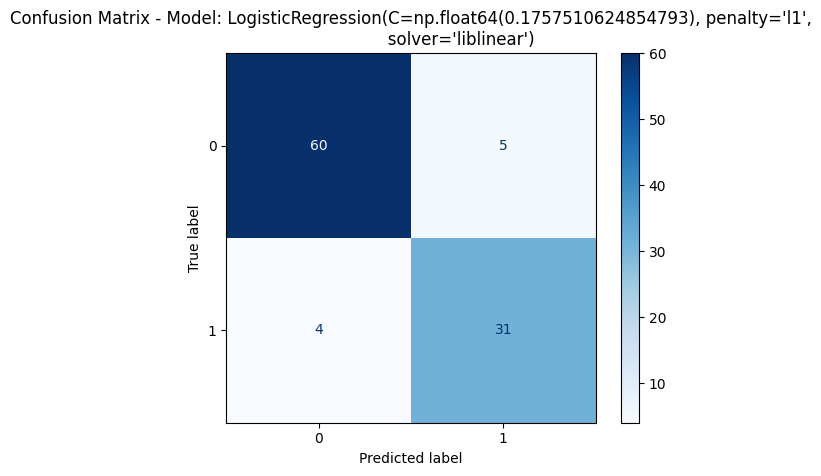

In [80]:
# Evaluate the best Lasso model
lasso = LogisticRegression(penalty='l1', solver='liblinear', C = best_C)

# Test the model
accuracy_score_test_LASSO, roc_auc_score_test_LASSO = useful_functions.test_model(lasso, X_train,X_test,
                                                                               y_train, y_test)

## 3. Test Different Models

In this part, we want to do hyper-parameter tuning for different chosen models. However we have a lot of features and probably some of them are correlated which can prevent the models from performing properly. Here we perform a PCA, keeping 50 features, as the cumulative explained variance for 50 features is around 98% (see graph of the begining of the notebook). With this dimensionality reduction, we test the models to see which one is the better and then we select the best one and perform PCA more precisely on the data, to see with which dimensions it performs the best.

In [81]:
# Define PCA for 50 features 
PCA_sst = PCA(n_components = 50)
PCA_sst.fit(X_train)

# Project data
Xp_train = PCA_sst.transform(X_train)
Xp_test = PCA_sst.transform(X_test)

In [82]:
# param grid for hyper-parameter tuning
qda_params = {'reg_param': [0, 0.1, 0.2, 0.5, 0.7, 0.9]}
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
param_grids = [qda_params, rf_params, svc_params, gb_params]

models = [QuadraticDiscriminantAnalysis(), RandomForestClassifier(), SVC(probability=True), GradientBoostingClassifier()]
model_names = ["QDA", "RandomForestClassifier", "SVC", "GradientBoostingClassifier"]

best_model_name = None
best_model = None
best_params = None
best_accuracy = 0
best_auc = 0

models_accuracies = []
models_auc = []

for i in range(len(models)):
    print(f"\nTuning {model_names[i]}")
    grid_search = GridSearchCV(models[i], param_grids[i], scoring = 'accuracy', cv = 5)
    grid_search.fit(Xp_train, y_train)

    # Best estimator and parameters
    best_estimator = grid_search.best_estimator_
    best_params_model = grid_search.best_params_
    best_accuracy_model = grid_search.best_score_

    # Evaluate on the test set
    y_test_pred = best_estimator.predict(Xp_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, best_estimator.predict_proba(Xp_test)[:, 1])

    print(f"Best Parameters for {model_names[i]}: {best_params_model}")
    print(f"Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")

    models_accuracies.append(test_accuracy)
    models_auc.append(test_auc)

    if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_auc > best_auc):
        best_model_name = model_names[i]
        best_model = best_estimator
        best_params = best_params_model
        best_accuracy = test_accuracy
        best_auc = test_auc

print(f"\nBest Model: {best_model_name}")
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best AUC: {best_auc:.4f}")


Tuning QDA
Best Parameters for QDA: {'reg_param': 0.9}
Test Accuracy: 0.6600, Test AUC: 0.8532

Tuning RandomForestClassifier
Best Parameters for RandomForestClassifier: {'max_depth': 20, 'n_estimators': 200}
Test Accuracy: 0.8200, Test AUC: 0.9193

Tuning SVC
Best Parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.8900, Test AUC: 0.9688

Tuning GradientBoostingClassifier
Best Parameters for GradientBoostingClassifier: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Test Accuracy: 0.8300, Test AUC: 0.9288

Best Model: SVC
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Accuracy: 0.8900
Best AUC: 0.9688


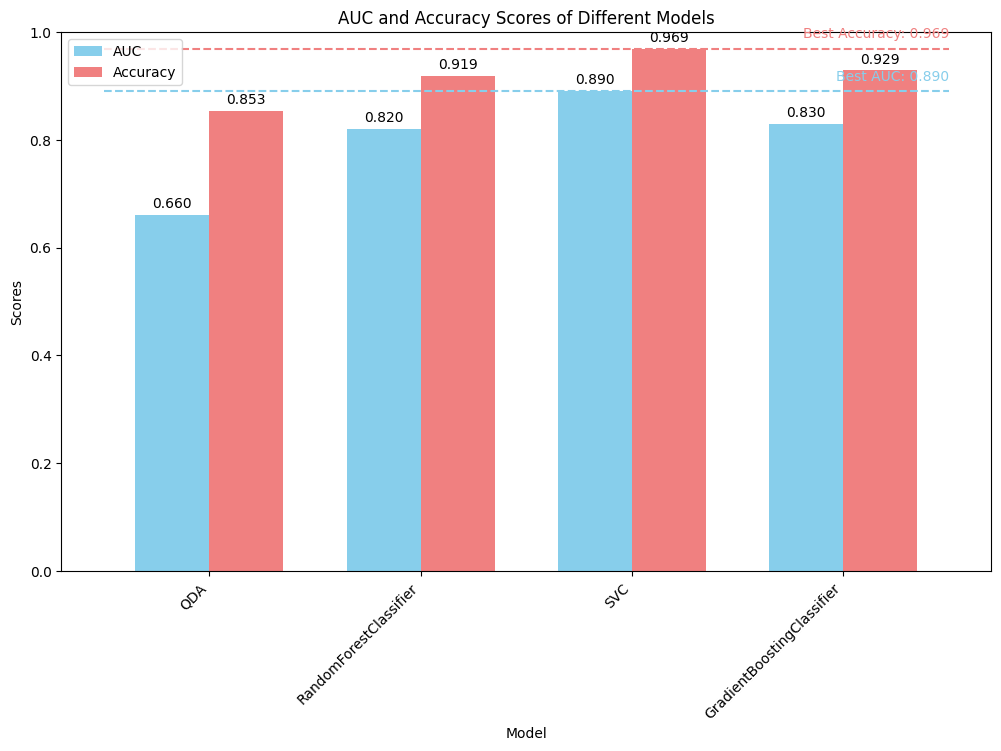

In [83]:
useful_functions.plot_score(model_names, models_accuracies, models_auc)

### Test the Best Model 

Best value of p - PCA : 11
Train Score for the best p: 0.9533333333333334
Test Score for the best p: 0.918918918918919


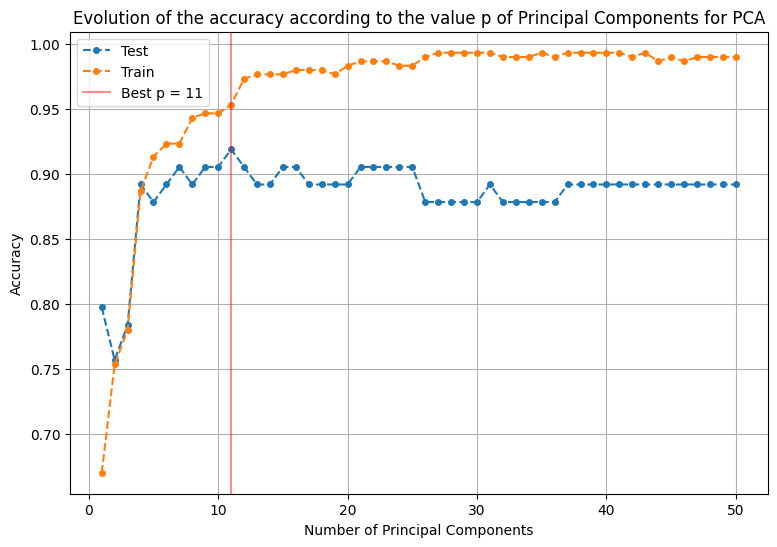

In [84]:
best_p_value, best_test_score_pca = useful_functions.validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, best_model,
                                    dim_max=50, verbose = True)

==== TRAIN ====
Accuracy for TRAIN data: 0.952
     AUC for TRAIN data: 0.987
==== TEST ====
Accuracy for TEST data: 0.900
     AUC for TEST data: 0.978


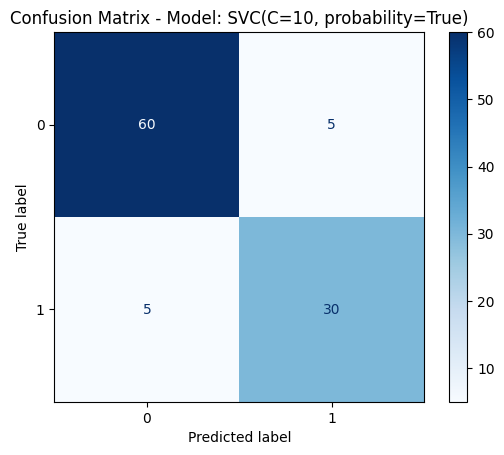

In [85]:
# PCA with p principal components
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Test the model
accuracy_score_test_SVC, roc_auc_score_test_SVC = useful_functions.test_model(best_model, X_train_projected,
                                                                            X_test_projected,
                                                                            y_train, y_test)

## 4. Neural Networks 

Let's try to use Neural Networks for now. We are going to project the data on 50 features and do our hyper-parameter tuning (just like in part 3) and then we will select the best model and tune the best p for the PCA.

In [86]:
param_grid = {
    'hidden_layer_sizes': [
        (128,),              
        (128, 64),           
        (128, 64, 32),       
        (256, 128, 64),      
    ],
    'alpha': [1e-4, 1e-3, 1e-2],  
    'solver': ['adam'],           
    'max_iter': [200],            
}

mlp = MLPClassifier(random_state = 42, early_stopping = True, validation_fraction = 0.2)

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
grid_search = GridSearchCV(estimator=mlp, param_grid = param_grid, scoring = 'accuracy', cv = cv)
grid_search.fit(Xp_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.3f}")

Best parameters found: {'alpha': 0.01, 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 200, 'solver': 'adam'}
Best cross-validated accuracy: 0.880


Best value of p - PCA : 10
Train Score for the best p: 0.95
Test Score for the best p: 0.918918918918919


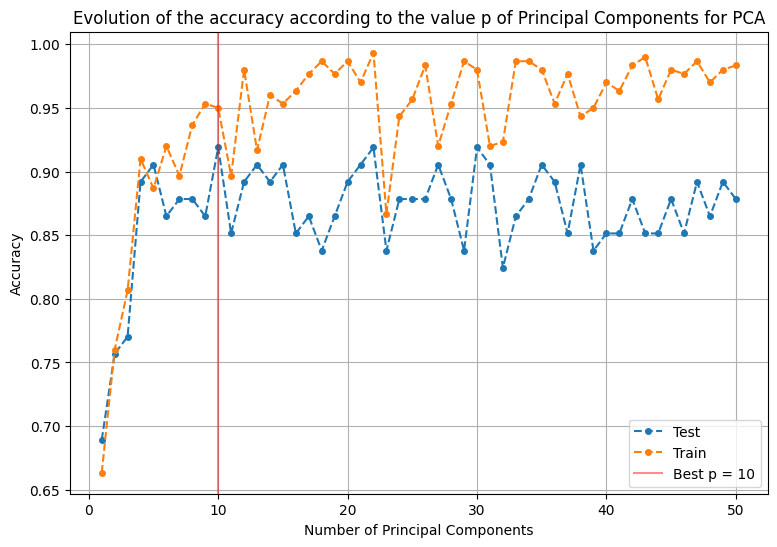

In [87]:
best_p_value, best_test_score_pca = useful_functions.validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, grid_search.best_estimator_,
                                    dim_max=50, verbose = True)

==== TRAIN ====
Accuracy for TRAIN data: 0.947
     AUC for TRAIN data: 0.983
==== TEST ====
Accuracy for TEST data: 0.900
     AUC for TEST data: 0.977


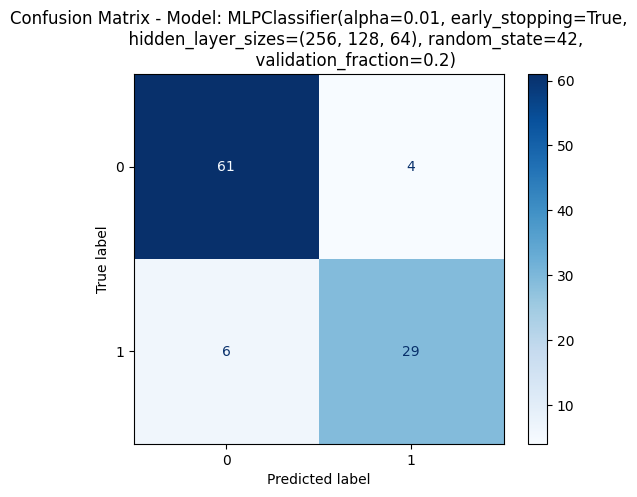

In [88]:
# PCA with p principal components
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Test the model
accuracy_score_test_MLP, roc_auc_score_test_MLP = useful_functions.test_model(grid_search.best_estimator_,
                                                                            X_train_projected,
                                                                            X_test_projected,
                                                                            y_train, y_test)

## 5. Recap of the Models

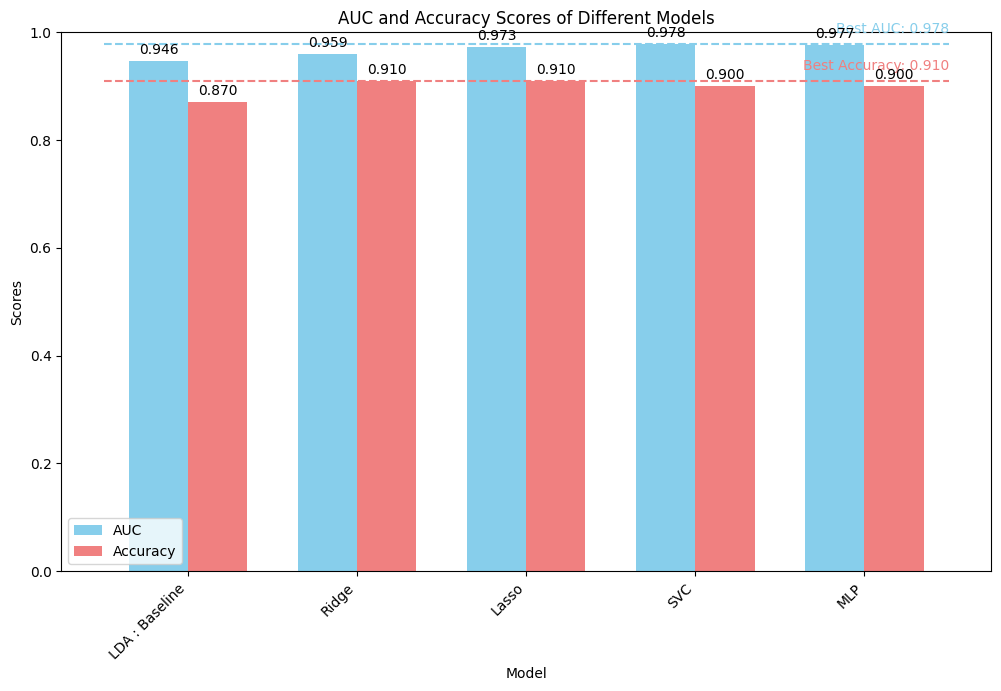

In [89]:
model_names = ["LDA : Baseline", "Ridge", "Lasso", "SVC", "MLP"]
models_accuracies = [accuracy_score_test_LDA, accuracy_score_test_RIDGE, accuracy_score_test_LASSO, accuracy_score_test_SVC, accuracy_score_test_MLP]
models_auc = [roc_auc_score_test_LDA, roc_auc_score_test_RIDGE, roc_auc_score_test_LASSO, roc_auc_score_test_SVC, roc_auc_score_test_MLP]
useful_functions.plot_score(model_names, models_auc, models_accuracies)

For a 1-month prediction, the best model we manage to get is SVC.

# Two-month prediction of El Niño Events

In this part, we will apply the 5 five models tested before and see if the results change as the prediction is for 2 months.

In [90]:
# Get the data for a 2-month prediction, split and scale the data
X2, y2 = useful_functions.get_data("data/preprocessed_data/nino_dataset_2m.npz")

==== GET THE DATA ====
Shape of X: (473, 64800)
Shape of y: (473,)
First 25 elements of y: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]


## 1. LDA

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (373, 64800)
Shape of y_train: (373,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== TRAIN ====
Accuracy for TRAIN data: 0.989
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.770
     AUC for TEST data: 0.870


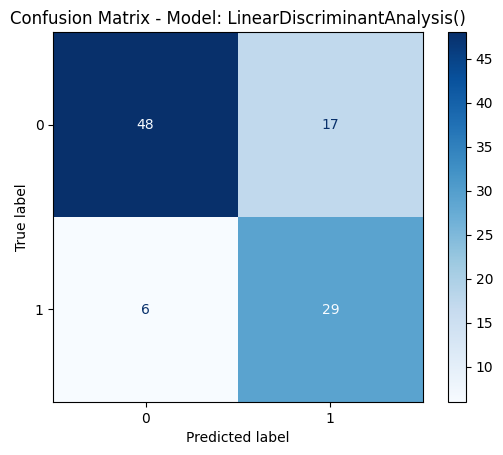

In [91]:
# Split the data for a first evaluation
X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X2, y2, RANDOM_SPLIT = False, train_size = 373)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Test the model
accuracy_score_test_lda, roc_auc_score_test_lda = useful_functions.test_model(lda, X_train,
                                                                              X_test, y_train, y_test)

The score is lower than with the first model for 1-month prediction. We face overfitting. Let us see if we can obtain better results

In [92]:
# We work with the original data and split it 
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    X2, y2, RANDOM_SPLIT=False, train_size=373
    )

X_train_cv, X_validation, y_train_cv, y_validation = useful_functions.split_scale_data(
    X_train, y_train, RANDOM_SPLIT=False, train_size=300, scale= False
    )

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (373, 64800)
Shape of y_train: (373,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (300, 64800)
Shape of y_train: (300,)
Shape of X_test: (73, 64800)
Shape of y_test: (73,)


Best value of p - PCA : 13
Train Score for the best p: 0.9
Test Score for the best p: 0.9178082191780822


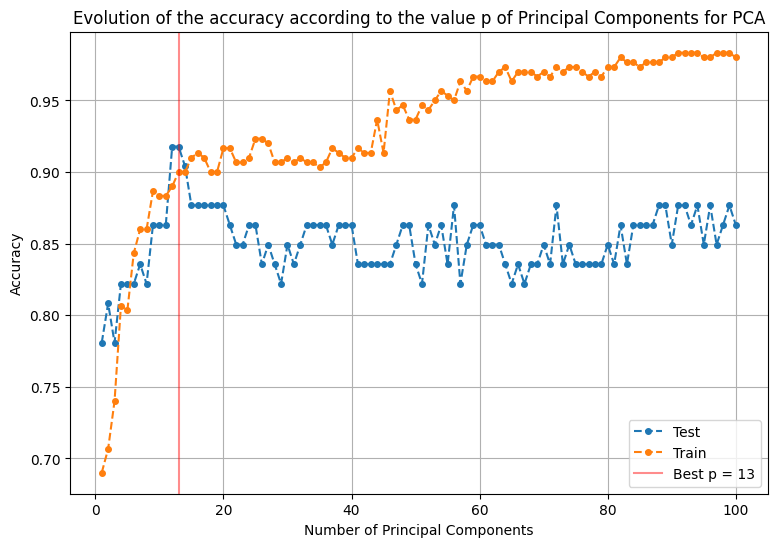

In [93]:
best_p_value, best_test_score_pca = useful_functions.validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, LinearDiscriminantAnalysis(),
                                    dim_max=100, verbose = True)

==== TRAIN ====
Accuracy for TRAIN data: 0.879
     AUC for TRAIN data: 0.946
==== TEST ====
Accuracy for TEST data: 0.910
     AUC for TEST data: 0.948


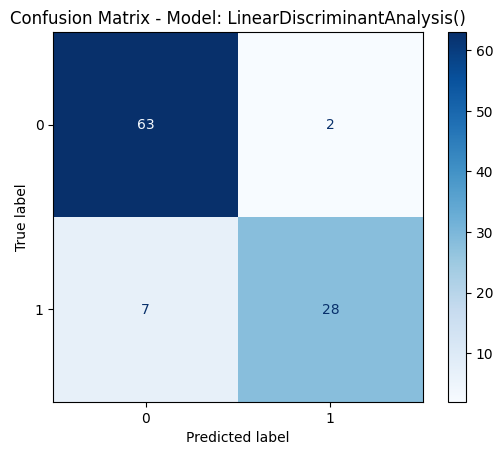

In [94]:
# PCA with p principal components
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Test the model
accuracy_score_test_LDA_2, roc_auc_score_test_LDA_2 = useful_functions.test_model(lda, X_train_projected,
                                                                            X_test_projected,
                                                                            y_train, y_test)

## 2. Ridge and Lasso for classification

### 2.1 Ridge Classification

In [95]:
best_lambda, max_accuracy_validation_Ridge, train_accuracy_Ridge, lambda_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = useful_functions.validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=1,
                                                                                           high_power=7,
                                                                                           nb_points=100)


Best parameter value after validation: 2656.1
Accuracy for training: 1.000
Accuracy for validation: 0.877


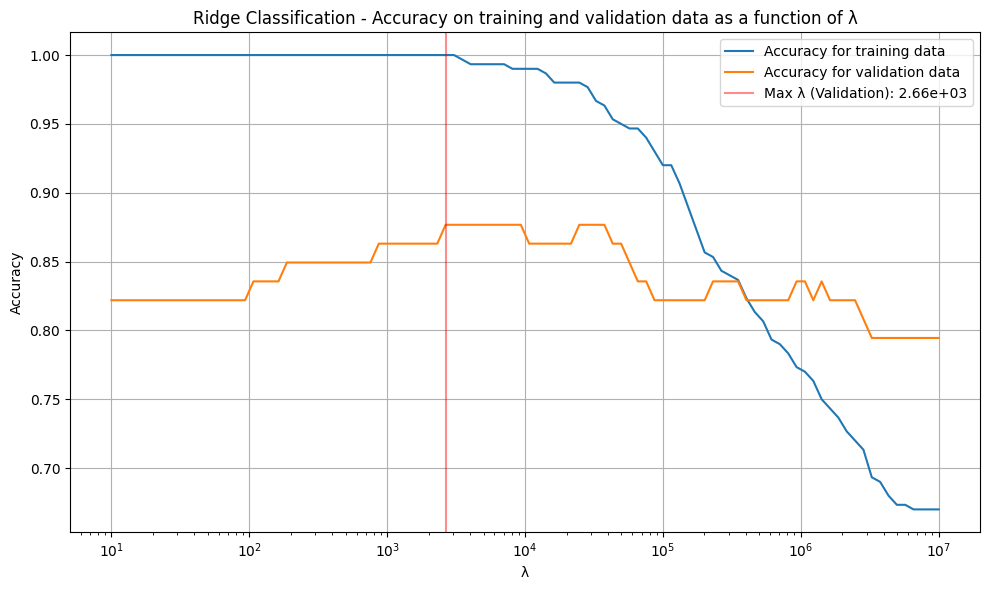

In [96]:
# Plot accuracy and coefficient evolution as a function of lambda
plt.figure(figsize = [10, 6])  

# Plot accuracy for training and validation sets
plt.semilogx(lambda_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(lambda_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_lambda, color = 'r', linestyle = '-', label = f'Max λ (Validation): {best_lambda:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.title('Ridge Classification - Accuracy on training and validation data as a function of λ')
plt.grid()
plt.tight_layout()
plt.show()

==== TRAIN ====
Accuracy for TRAIN data: 1.000
     AUC for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.840
     AUC for TEST data: 0.920


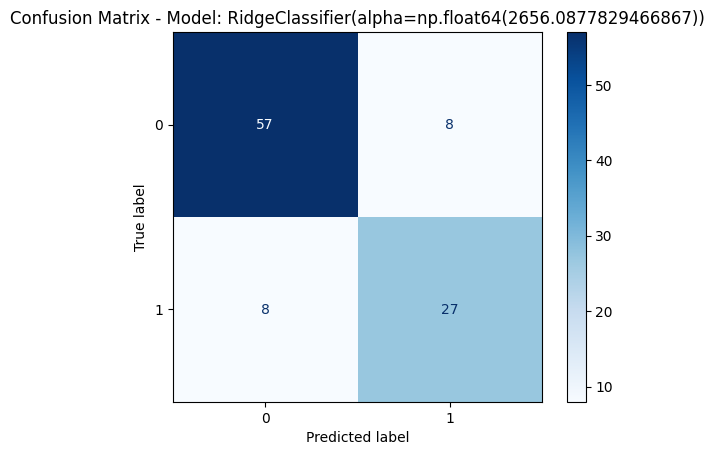

In [97]:
# Evaluate the best Ridge model
ridge = RidgeClassifier(alpha = best_lambda)

# Test the model
accuracy_score_test_RIDGE_2, roc_auc_score_test_RIDGE_2 = useful_functions.test_model(ridge, X_train,X_test,
                                                                               y_train, y_test)

### 2.2 Lasso Classification

In [98]:
best_C, max_accuracy_validation_Lasso, train_accuracy_Lasso, C_values, coefficients, accuracy_train_cv_list, accuracy_valid_list = useful_functions.validation(X_train_cv,
                                                                                           y_train_cv,
                                                                                           X_validation,
                                                                                           y_validation,
                                                                                           low_power=-3,
                                                                                           high_power=2,
                                                                                           nb_points=50,
                                                                                           Ridge=False)


Best parameter value after validation: 0.2
Accuracy for training: 0.970
Accuracy for validation: 0.863


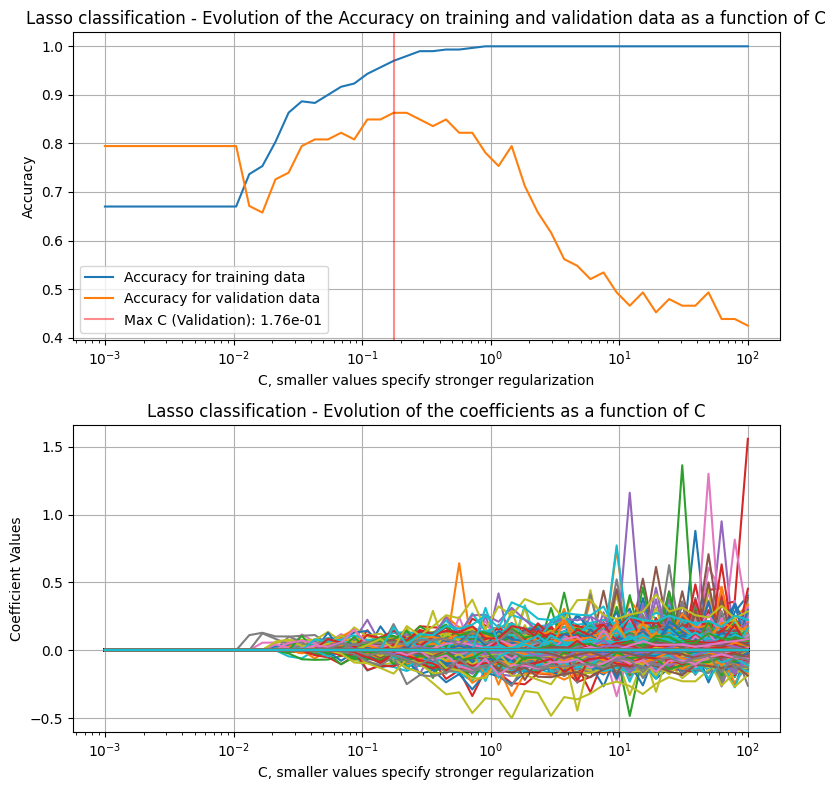

In [99]:
# Plot the results
plt.figure(figsize = [8,8])
plt.subplot(2,1,1)

plt.semilogx(C_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(C_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = best_C, color = 'r', linestyle = '-', label = f'Max C (Validation): {best_C:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Accuracy')
plt.title('Lasso classification - Evolution of the Accuracy on training and validation data as a function of C')
plt.grid()

plt.subplot(2,1,2)
plt.semilogx(C_values, coefficients[:, 0])
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Lasso classification - Evolution of the coefficients as a function of C')

plt.tight_layout() 

==== TRAIN ====
Accuracy for TRAIN data: 0.962
     AUC for TRAIN data: 0.992
==== TEST ====
Accuracy for TEST data: 0.850
     AUC for TEST data: 0.913


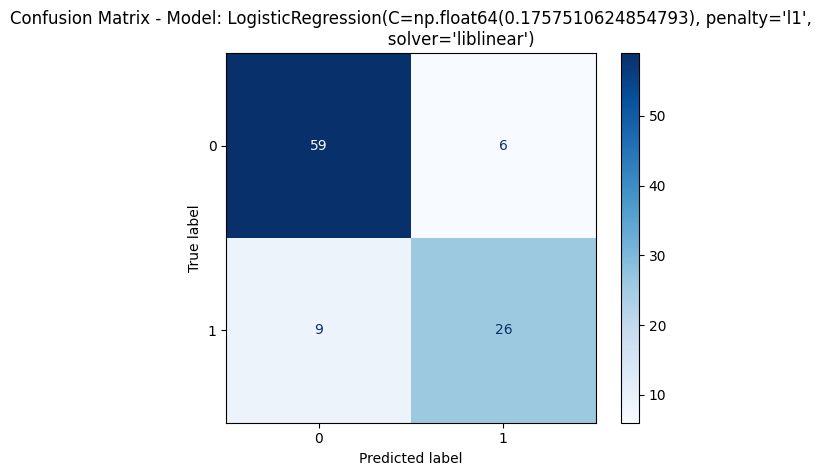

In [100]:
# Evaluate the best Lasso model
lasso = LogisticRegression(penalty='l1', solver='liblinear', C = best_C)

# Test the model
accuracy_score_test_LASSO_2, roc_auc_score_test_LASSO_2 = useful_functions.test_model(lasso, X_train,X_test,
                                                                               y_train, y_test)

## 3. SVC

In [101]:
# Define PCA for 50 features 
PCA_sst = PCA(n_components = 50)
PCA_sst.fit(X_train)

# Project data
Xp_train = PCA_sst.transform(X_train)
Xp_test = PCA_sst.transform(X_test)

In [102]:
# param grid for hyper-parameter tuning
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
param_grids = [svc_params]

models = [SVC(probability=True)]
model_names = ["SVC"]

best_model_name = None
best_model = None
best_params = None
best_accuracy = 0
best_auc = 0

models_accuracies = []
models_auc = []

for i in range(len(models)):
    print(f"\nTuning {model_names[i]}")
    grid_search = GridSearchCV(models[i], param_grids[i], scoring = 'accuracy', cv = 5)
    grid_search.fit(Xp_train, y_train)

    # Best estimator and parameters
    best_estimator = grid_search.best_estimator_
    best_params_model = grid_search.best_params_
    best_accuracy_model = grid_search.best_score_

    # Evaluate on the test set
    y_test_pred = best_estimator.predict(Xp_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, best_estimator.predict_proba(Xp_test)[:, 1])

    print(f"Best Parameters for {model_names[i]}: {best_params_model}")
    print(f"Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")

    models_accuracies.append(test_accuracy)
    models_auc.append(test_auc)

    if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_auc > best_auc):
        best_model_name = model_names[i]
        best_model = best_estimator
        best_params = best_params_model
        best_accuracy = test_accuracy
        best_auc = test_auc


Tuning SVC
Best Parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.8400, Test AUC: 0.9275


Best value of p - PCA : 18
Train Score for the best p: 0.9766666666666667
Test Score for the best p: 0.8904109589041096


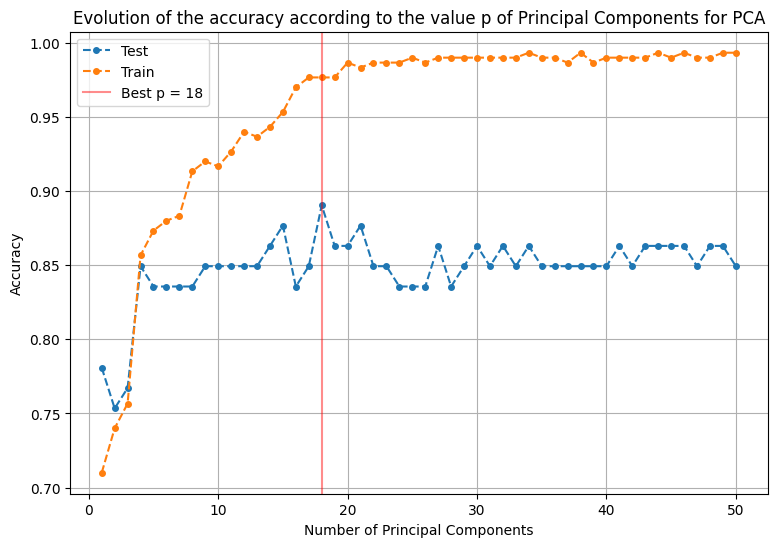

In [103]:
best_p_value, best_test_score_pca = useful_functions.validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, best_model,
                                    dim_max=50, verbose = True)

==== TRAIN ====
Accuracy for TRAIN data: 0.960
     AUC for TRAIN data: 0.988
==== TEST ====
Accuracy for TEST data: 0.880
     AUC for TEST data: 0.945


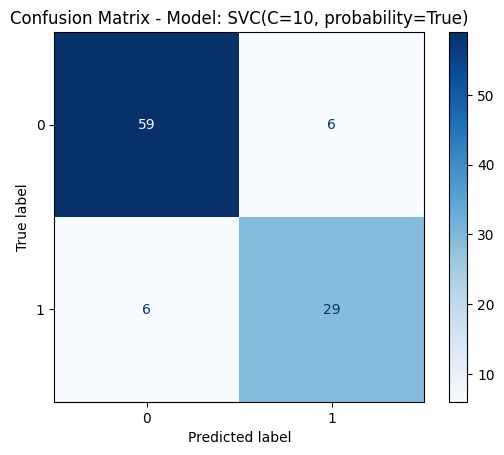

In [104]:
# PCA with p principal components
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Test the model
accuracy_score_test_SVC_2, roc_auc_score_test_SVC_2 = useful_functions.test_model(best_model, X_train_projected,
                                                                            X_test_projected,
                                                                            y_train, y_test)

## 4. Neural Networks

In [105]:
param_grid = {
    'hidden_layer_sizes': [
        (128,),              
        (128, 64),           
        (128, 64, 32),       
        (256, 128, 64),      
    ],
    'alpha': [1e-4, 1e-3, 1e-2],  
    'solver': ['adam'],           
    'max_iter': [200],            
}

mlp = MLPClassifier(random_state = 42, early_stopping = True, validation_fraction = 0.2)

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
grid_search = GridSearchCV(estimator=mlp, param_grid = param_grid, scoring = 'accuracy', cv = cv)
grid_search.fit(Xp_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.3f}")

Best parameters found: {'alpha': 0.001, 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 200, 'solver': 'adam'}
Best cross-validated accuracy: 0.877


Best value of p - PCA : 30
Train Score for the best p: 0.9733333333333334
Test Score for the best p: 0.9315068493150684


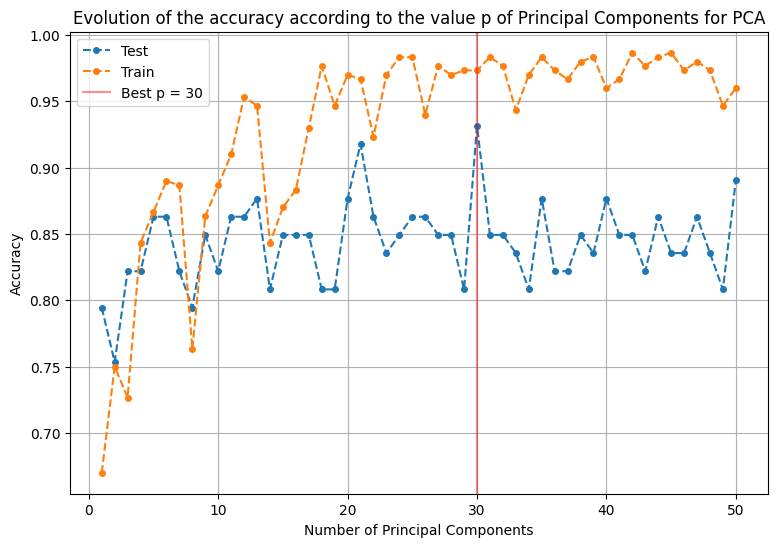

In [106]:
best_p_value, best_test_score_pca = useful_functions.validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, grid_search.best_estimator_,
                                    dim_max=50, verbose = True)

==== TRAIN ====
Accuracy for TRAIN data: 0.987
     AUC for TRAIN data: 0.997
==== TEST ====
Accuracy for TEST data: 0.880
     AUC for TEST data: 0.949


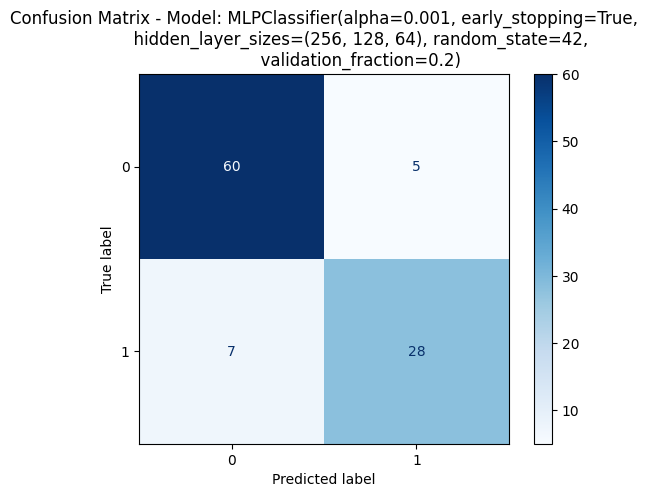

In [107]:
# PCA with p principal components
pca = PCA(n_components = best_p_value)
pca.fit(X_train)

# Project data
X_train_projected = pca.transform(X_train)
X_test_projected = pca.transform(X_test)

# Test the model
accuracy_score_test_MLP_2, roc_auc_score_test_MLP_2 = useful_functions.test_model(grid_search.best_estimator_,
                                                                            X_train_projected,
                                                                            X_test_projected,
                                                                            y_train, y_test)

## 5. Recap of the models

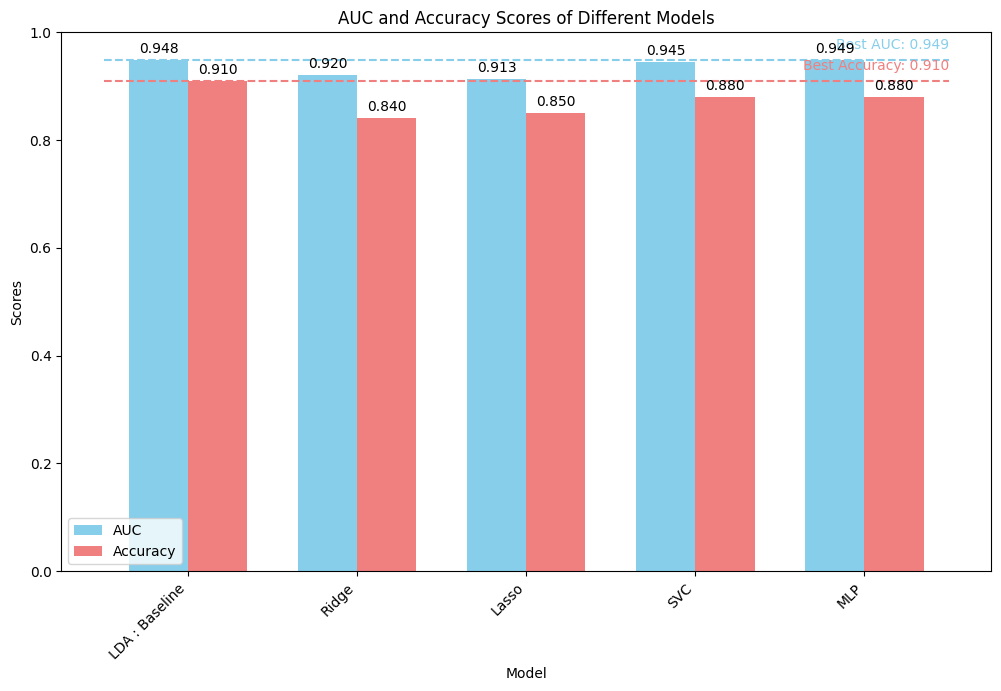

In [108]:
model_names = ["LDA : Baseline", "Ridge", "Lasso", "SVC", "MLP"]
models_accuracies = [accuracy_score_test_LDA_2, accuracy_score_test_RIDGE_2, accuracy_score_test_LASSO_2, accuracy_score_test_SVC_2, accuracy_score_test_MLP_2]
models_auc = [roc_auc_score_test_LDA_2, roc_auc_score_test_RIDGE_2, roc_auc_score_test_LASSO_2, roc_auc_score_test_SVC_2, roc_auc_score_test_MLP_2]
useful_functions.plot_score(model_names, models_auc, models_accuracies)

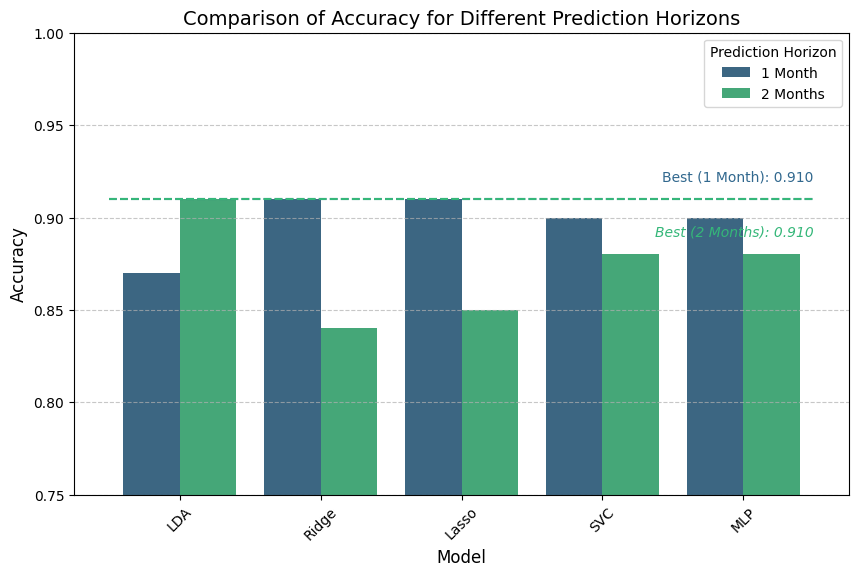

In [109]:
data = {
    'Model': ['LDA', 'Ridge', 'Lasso', 'SVC', 'MLP'],
    'Accuracy_1_month': [accuracy_score_test_LDA, accuracy_score_test_RIDGE, accuracy_score_test_LASSO, accuracy_score_test_SVC, accuracy_score_test_MLP],
    'Accuracy_2_months': [accuracy_score_test_LDA_2, accuracy_score_test_RIDGE_2, accuracy_score_test_LASSO_2, accuracy_score_test_SVC_2, accuracy_score_test_MLP_2]
}

# Créer un DataFrame
accuracy_df = pd.DataFrame(data)

# Reshape the data
accuracy_melted = pd.melt(accuracy_df, id_vars=['Model'], 
                          value_vars=['Accuracy_1_month', 'Accuracy_2_months'],
                          var_name='Prediction_Horizon', value_name='Accuracy')
accuracy_melted['Prediction_Horizon'] = accuracy_melted['Prediction_Horizon'].replace({
    'Accuracy_1_month': '1 Month',
    'Accuracy_2_months': '2 Months'
})

# Find the best scores
best_scores = accuracy_melted.loc[accuracy_melted.groupby('Prediction_Horizon')['Accuracy'].idxmax()]


# Visualization
plt.figure(figsize=(10, 6))

palette = sns.color_palette('viridis', n_colors=len(accuracy_melted['Prediction_Horizon'].unique()))
colors = dict(zip(['1 Month', '2 Months'], palette))

ax = sns.barplot(data=accuracy_melted, x='Model', y='Accuracy', hue='Prediction_Horizon', palette=palette)
plt.title('Comparison of Accuracy for Different Prediction Horizons', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0.75, 1.0)
plt.legend(title='Prediction Horizon', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal lines
for _, row in best_scores.iterrows():
    horizon = row['Prediction_Horizon']
    color = colors[horizon] 

    ax.hlines(y=row['Accuracy'], xmin=-0.5, xmax=4.5, colors=color, linestyles='--', linewidth=1.5)

    if horizon == '1 Month': 
        ax.text(4.5, row['Accuracy'] + 0.01, f"Best ({horizon}): {row['Accuracy']:.3f}",
                color=color, ha='right', fontsize=10)
    elif horizon == '2 Months':
        ax.text(4.5, row['Accuracy'] - 0.02, f"Best ({horizon}): {row['Accuracy']:.3f}",
                color=color, ha='right', fontsize=10, style='italic')

plt.show()


# Predictions for more months

In [110]:
#Chose the number of months for the prediction 
n_months = 12

In [111]:
def get_pred_SVC(list_number_months):
    # Initialize output
    list_test_accuracy_SVC = []
    list_test_roc_auc_SVC = []

    for N in list_number_months:
        print(f"#################### {N}-months prediction ####################")
        # Get the data for a N-month prediction, split and scale the data
        X, y = useful_functions.get_data(f"data/preprocessed_data/nino_dataset_{N}m.npz")
        # Split the data
        X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374 - (N-1), verbose=False)

        ############################# Tune SVC
        print('######### Tune SVC ...')
        
        # Define PCA for 50 features 
        PCA_sst = PCA(n_components = 50)
        PCA_sst.fit(X_train)

        Xp_train = PCA_sst.transform(X_train)
        Xp_test = PCA_sst.transform(X_test)
        # param grid for hyper-parameter tuning
        svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
        param_grids = [svc_params]

        models = [SVC(probability=True)]
        model_names = ["SVC"]

        best_model_name = None
        best_model = None
        best_params = None
        best_accuracy = 0
        best_auc = 0

        models_accuracies = []
        models_auc = []

        for i in range(len(models)):
            print(f"\nTuning {model_names[i]}")
            grid_search = GridSearchCV(models[i], param_grids[i], scoring = 'accuracy', cv = 5)
            grid_search.fit(Xp_train, y_train)

            # Best estimator and parameters
            best_estimator = grid_search.best_estimator_
            best_params_model = grid_search.best_params_
            best_accuracy_model = grid_search.best_score_

            # Evaluate on the test set
            y_test_pred = best_estimator.predict(Xp_test)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            test_auc = roc_auc_score(y_test, best_estimator.predict_proba(Xp_test)[:, 1])

            print(f"Best Parameters for {model_names[i]}: {best_params_model}")
            print(f"Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")

            models_accuracies.append(test_accuracy)
            models_auc.append(test_auc)

            if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_auc > best_auc):
                best_model_name = model_names[i]
                best_model = best_estimator
                best_params = best_params_model
                best_accuracy = test_accuracy
                best_auc = test_auc
        p_values = np.linspace(1, 50, 50).astype(int)
        p_values = p_values.astype(int)
        test_score_accuracy = []
        train_score_accuracy = []
        models_pca = []

        ############################# Tune PCA
        print('######### Tune PCA ...')
        best_p_value, best_test_score_pca = useful_functions.validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, best_model,
                                    dim_max=50, verbose = False)

        ############################# TEST
        print('######### TEST ...')
        # PCA with p principal components
        pca = PCA(n_components = best_p_value)
        pca.fit(X_train)

        # Project data
        X_train_projected = pca.transform(X_train)
        X_test_projected = pca.transform(X_test)

        # Test the model
        accuracy_score_test_SVC, roc_auc_score_test_SVC = useful_functions.test_model(best_model, X_train_projected,
                                                                                    X_test_projected,
                                                                                   y_train, y_test)
        # Print and get the outputs
        list_test_accuracy_SVC.append(accuracy_score_test_SVC)
        list_test_roc_auc_SVC.append(roc_auc_score_test_SVC)
        
    return list_test_accuracy_SVC, list_test_roc_auc_SVC

#################### 1-months prediction ####################
==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
######### Tune SVC ...

Tuning SVC
Best Parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.8900, Test AUC: 0.9688
######### Tune PCA ...
######### TEST ...
==== TRAIN ====
Accuracy for TRAIN data: 0.968
     AUC for TRAIN data: 0.991
==== TEST ====
Accuracy for TEST data: 0.890
     AUC for TEST data: 0.972
#################### 2-months prediction ####################
==== GET THE DATA ====
Shape of X: (473, 64800)
Shape of y: (473,)
First 25 elements of y: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
######### Tune SVC ...

Tuning SVC
Best Parameters for SVC: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.8500, Test AUC: 0.9288
######### Tune PCA ...
######### TEST ...
==== TRAIN ====
Accuracy for TRAIN data: 0.938
     AUC for TRAIN data: 0.985
==== TEST ====
Accura

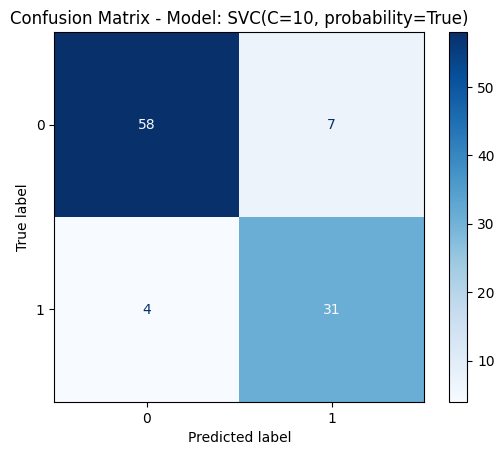

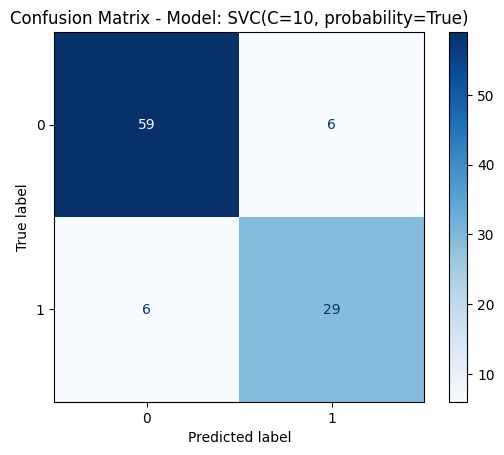

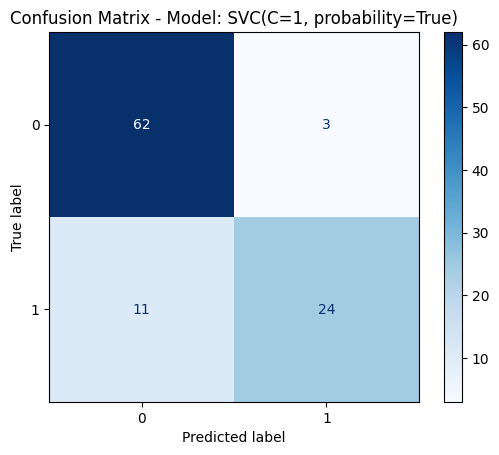

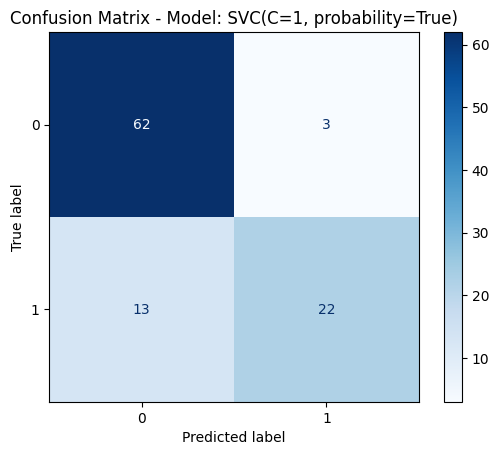

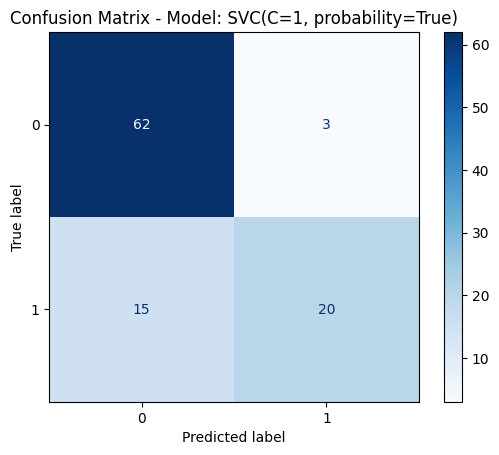

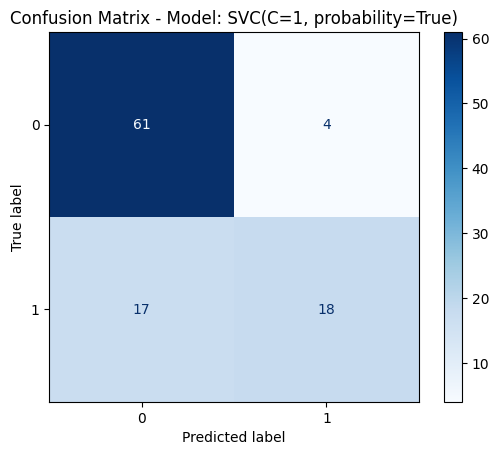

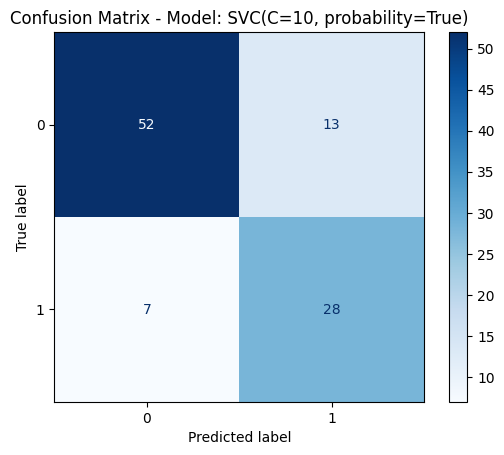

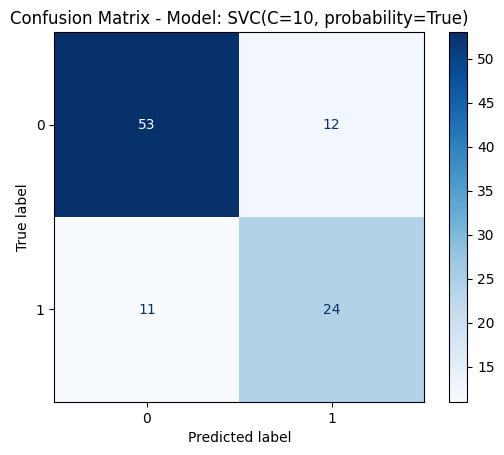

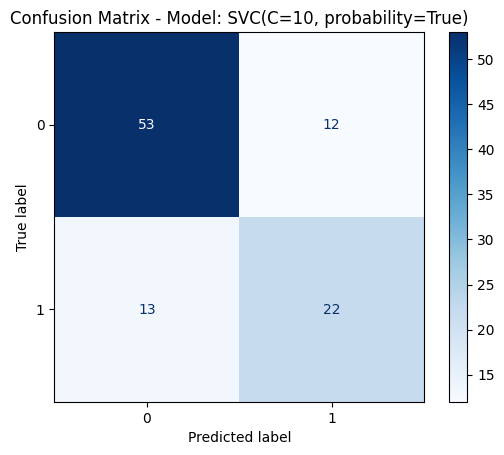

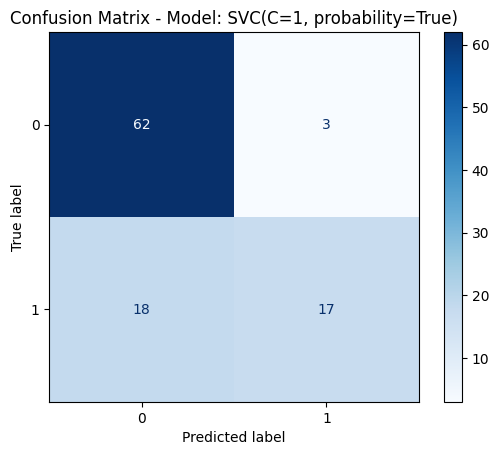

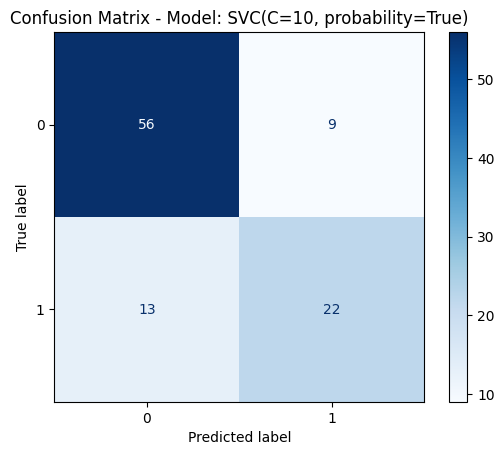

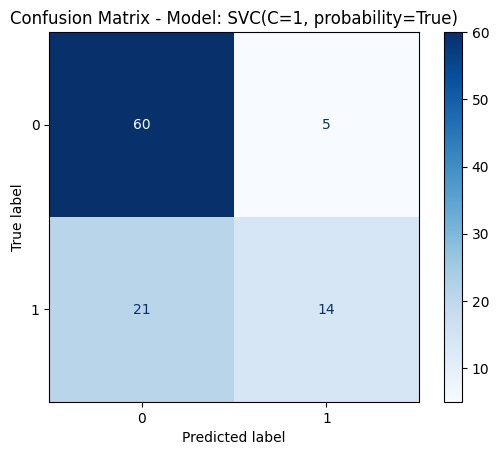

In [112]:
list_test_accuracy_SVC, list_test_roc_auc_SVC = get_pred_SVC(list_number_months=[i for i in range(1,n_months + 1)])

In [113]:
def get_pred_LDA(list_number_months):
    # Initialize output
    list_test_accuracy_LDA = []
    list_test_roc_auc_LDA = []

    for N in list_number_months:
        print(f"#################### {N}-months prediction ####################")
        # Get the data for a N-month prediction, split and scale the data
        X, y = useful_functions.get_data(f"data/preprocessed_data/nino_dataset_{N}m.npz")
        # Split the data
        X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374 - (N-1), verbose=False)

        ############################# Tune PCA
        print('######### Tune PCA ...')
        best_p_value, best_test_score_pca = useful_functions.validation_PCA(X_train_cv, y_train_cv,
                                    X_validation, y_validation, LinearDiscriminantAnalysis(),
                                    dim_max=50, verbose = False)

        ############################# TEST
        print('######### TEST ...')
        # PCA with p principal components
        pca = PCA(n_components = best_p_value)
        pca.fit(X_train)

        # Project data
        X_train_projected = pca.transform(X_train)
        X_test_projected = pca.transform(X_test)

        # Test the model
        accuracy_score_test_LDA, roc_auc_score_test_LDA = useful_functions.test_model(LinearDiscriminantAnalysis(), X_train_projected,
                                                                                    X_test_projected,
                                                                                   y_train, y_test)
        # Print and get the outputs
        list_test_accuracy_LDA.append(accuracy_score_test_LDA)
        list_test_roc_auc_LDA.append(roc_auc_score_test_LDA)

    return list_test_accuracy_LDA, list_test_roc_auc_LDA


#################### 1-months prediction ####################
==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
######### Tune PCA ...
######### TEST ...
==== TRAIN ====
Accuracy for TRAIN data: 0.914
     AUC for TRAIN data: 0.967
==== TEST ====
Accuracy for TEST data: 0.890
     AUC for TEST data: 0.953
#################### 2-months prediction ####################
==== GET THE DATA ====
Shape of X: (473, 64800)
Shape of y: (473,)
First 25 elements of y: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
######### Tune PCA ...
######### TEST ...
==== TRAIN ====
Accuracy for TRAIN data: 0.879
     AUC for TRAIN data: 0.945
==== TEST ====
Accuracy for TEST data: 0.910
     AUC for TEST data: 0.948
#################### 3-months prediction ####################
==== GET THE DATA ====
Shape of X: (472, 64800)
Shape of y: (472,)
First 25 elements of y: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 

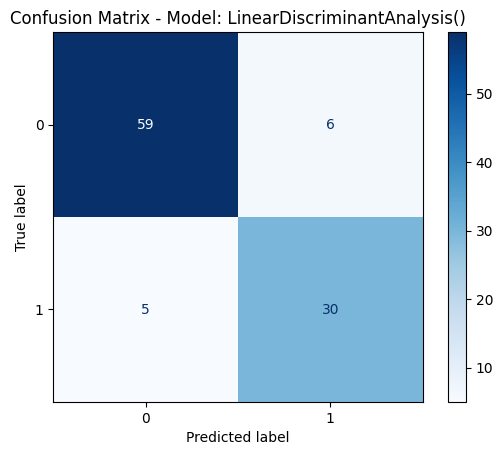

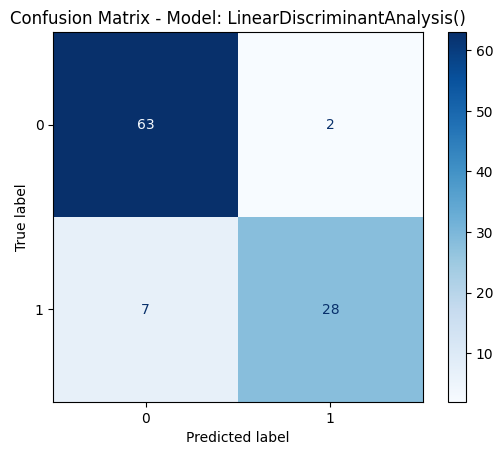

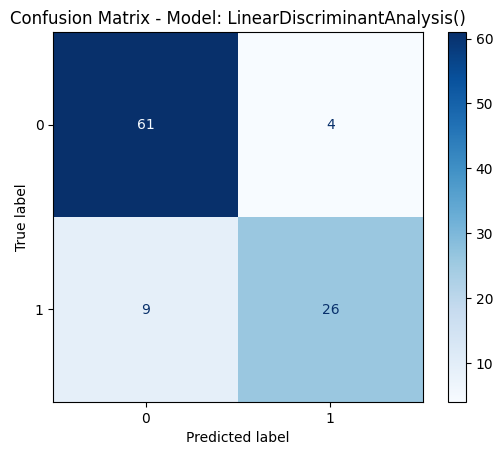

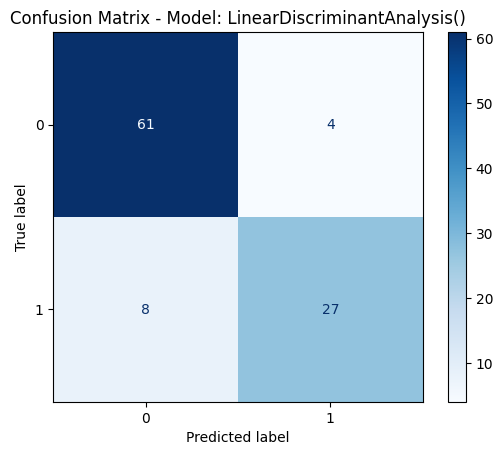

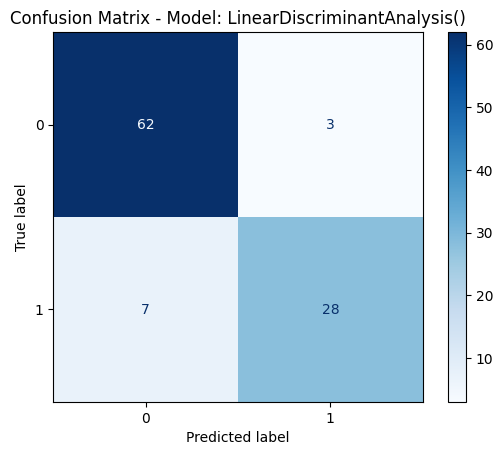

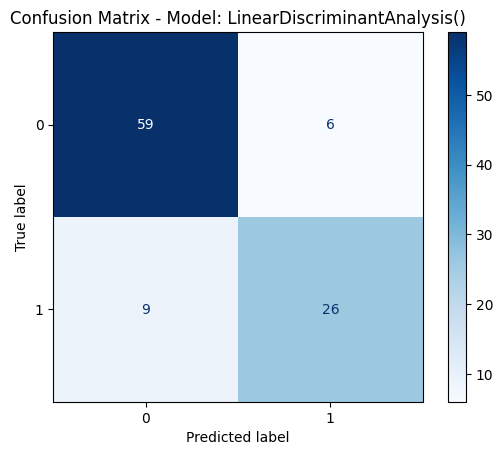

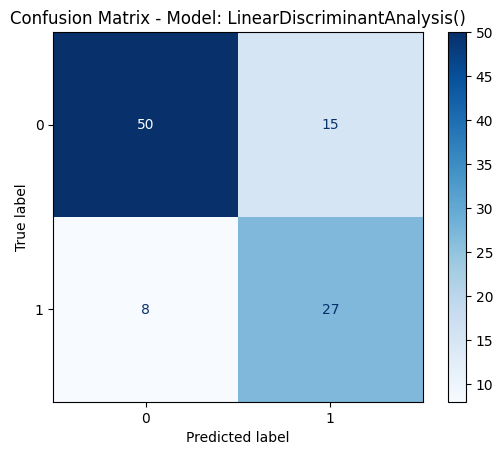

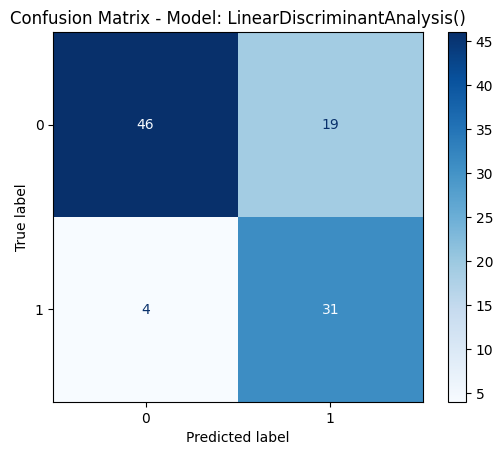

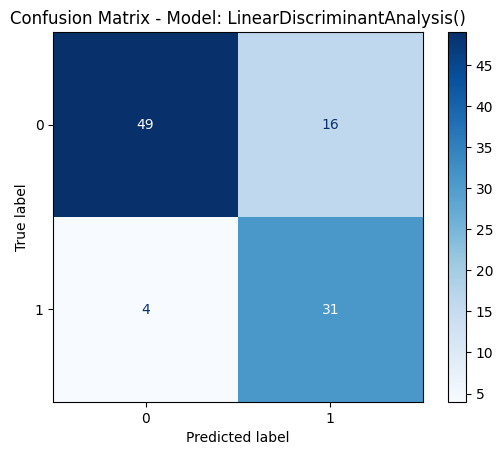

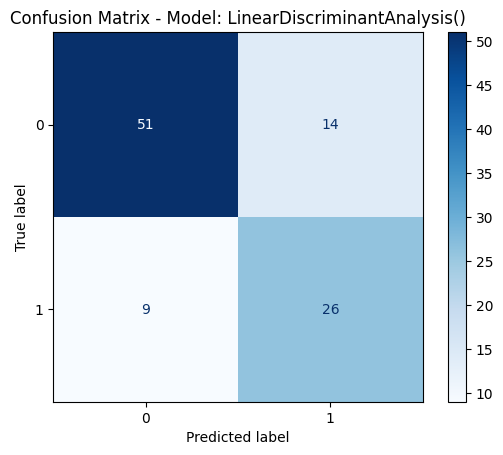

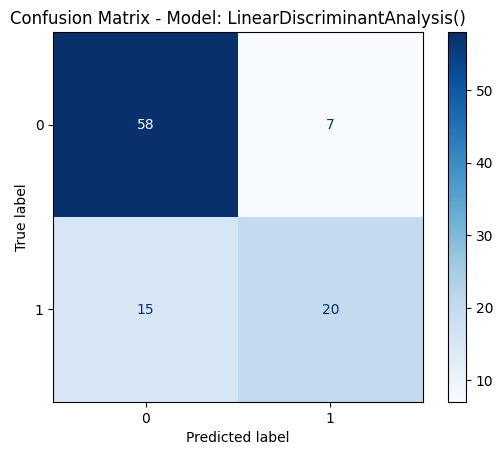

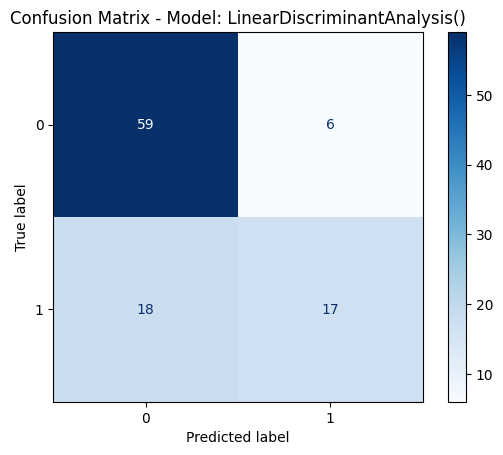

In [114]:
list_test_accuracy_LDA, list_test_roc_auc_LDA = get_pred_LDA(list_number_months=[i for i in range(1,n_months + 1)])

In [115]:
# Compare to the stupid model that predicts no el Nino everytime 
def get_pred_stupid(list_number_months):
    # Initialize output
    list_test_accuracy_stupid = []

    for N in list_number_months:
        print(f"#################### {N}-months prediction ####################")
        # Get the data for a N-month prediction, split and scale the data
        X, y = useful_functions.get_data(f"data/preprocessed_data/nino_dataset_{N}m.npz")
        # Split the data
        X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374 - (N-1), verbose=False)
        y_stupid = np.zeros(y_test.shape)
        accuracy_stupid = accuracy_score(y_stupid, y_test)
        list_test_accuracy_stupid.append(accuracy_stupid)
    return(list_test_accuracy_stupid)

list_test_accuracy_stupid = get_pred_stupid(list_number_months=[i for i in range(1,n_months + 1)])

#################### 1-months prediction ####################
==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
#################### 2-months prediction ####################
==== GET THE DATA ====
Shape of X: (473, 64800)
Shape of y: (473,)
First 25 elements of y: [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
#################### 3-months prediction ####################
==== GET THE DATA ====
Shape of X: (472, 64800)
Shape of y: (472,)
First 25 elements of y: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
#################### 4-months prediction ####################
==== GET THE DATA ====
Shape of X: (471, 64800)
Shape of y: (471,)
First 25 elements of y: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
#################### 5-months prediction ####################
==== GET THE DATA ====
Shape of X: (470, 64800)
Shape of y: (470,)
First 25 elements of y: [1 1 1 1 1 1 1 1 1 1 1 1 1 

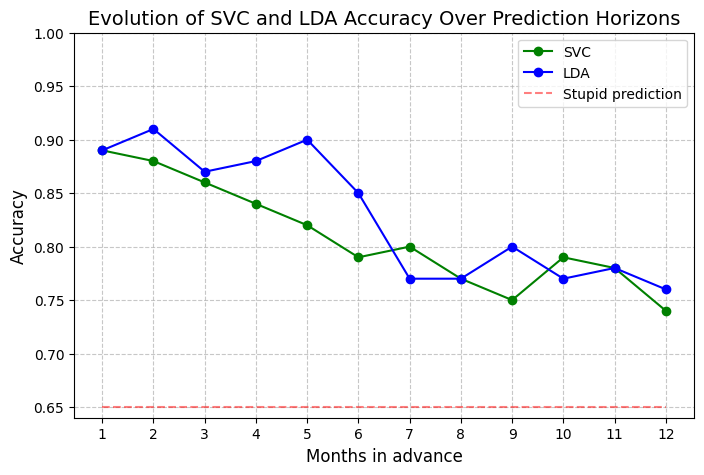

In [116]:
# Plot the evolution of accuracy
N = [i for i in range(1,n_months + 1)]
plt.figure(figsize=(8, 5))
plt.plot(N, list_test_accuracy_SVC, marker='o', color='green', label='SVC')
plt.plot(N, list_test_accuracy_LDA, marker='o', color='blue', label='LDA')
plt.plot(N, list_test_accuracy_stupid, color = 'red', linestyle='--', alpha=0.5, label='Stupid prediction')

# Add details to the plot
plt.title('Evolution of SVC and LDA Accuracy Over Prediction Horizons', fontsize=14)
plt.xlabel('Months in advance', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(N)
plt.ylim(min(list_test_accuracy_SVC) - 0.1 , 1.0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)